In [54]:
import sys
import logging
import random

import pandas as pd
import matplotlib.pyplot as plt
import cstrees.cstree as ct
import cstrees.scoring as sc
import cstrees.stage as st
import cstrees.learning as ctl
import networkx as nx
import numpy as np
import pp

%load_ext autoreload
%autoreload 2
#logging.basicConfig(stream=sys.stderr, level=logging.DEBUG)
logging.basicConfig(stream=sys.stderr, level=logging.ERROR)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


      a  b  c
0     2  2  2
1     1  1  1
2     0  0  0
3     0  0  0
4     1  0  1
...  .. .. ..
4996  0  0  1
4997  0  0  1
4998  1  0  1
4999  1  0  1
5000  0  0  0

[5001 rows x 3 columns]


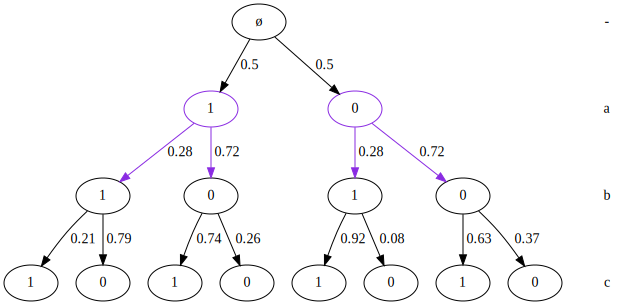

In [106]:
np.random.seed(50)
tree = ct.CStree([2] * 3, labels=["a", "b", "c"])

# V-structure
tree.update_stages({
    0: [st.Stage([{0, 1}])],
    1: [st.Stage([0, 0]), st.Stage([0, 1]), st.Stage([1, 0]), st.Stage([1, 1])]})

tree.sample_stage_parameters(alpha=1.0)

a = tree.plot()

# a.draw("testplot.png")
x = tree.sample(5000)
print(x)

true_cdags = tree.to_minimal_context_graphs()
for key, val in true_cdags.items():
    agraph = nx.nx_agraph.to_agraph(val)
    agraph.layout("dot")
    agraph.draw("testing/"+str(key) + "_true.png",
                args='-Glabel="'+str(key)+'"   ')
a


In [95]:
tree.to_df()

,a,b,c
0,2,2,2
1,*,-,-
2,0,0,-
3,0,1,-
4,1,0,-
5,1,1,-


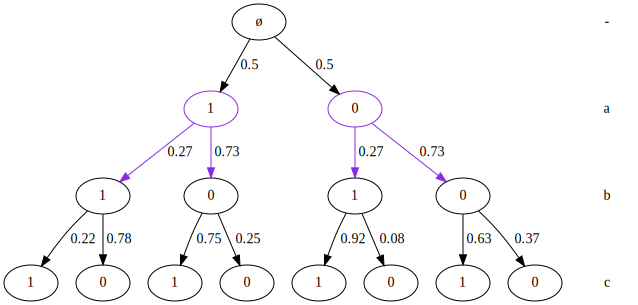

In [105]:
tree.estimate_stage_parameters(x)
tree.plot()

Context score tables:   0%|          | 0/3 [00:00<?, ?it/s]

Order score tables: 100%|██████████| 3/3 [00:00<00:00, 566.08it/s]


optimal order: ['a', 'b', 'c'], score -9590.972971557952
stages :{0: [<cstrees.stage.Stage object at 0x7fe3cdc13d60>], 1: [<cstrees.stage.Stage object at 0x7fe3cc717a00>, <cstrees.stage.Stage object at 0x7fe3cc717670>, <cstrees.stage.Stage object at 0x7fe3cc715780>, <cstrees.stage.Stage object at 0x7fe3cc714970>], 2: [], -1: [<cstrees.stage.Stage object at 0x7fe3cedf4310>]}

Optimal CStree stagings per level:
level 0:
[{0, 1}]
level 1:
[0, 0]
[1, 0]
[0, 1]
[1, 1]
level 2:


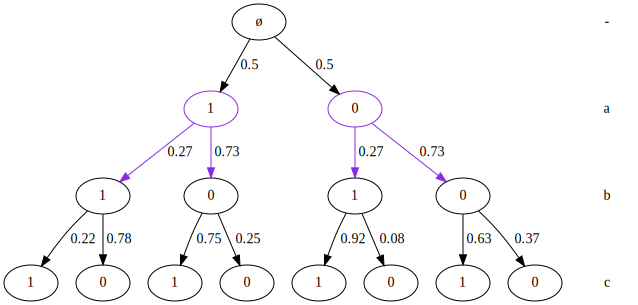

In [108]:

score_table, context_scores, context_counts = sc.order_score_tables(x, 
                                                                    max_cvars=2, 
                                                                    alpha_tot=1.0, 
                                                                    method="BDeu")

optord, score = ctl._find_optimal_order(score_table)
print("optimal order: {}, score {}".format(optord, score))

opttree = ctl._optimal_cstree_given_order(optord, context_scores, max_cvars=2)
print("stages :{}".format(opttree.stages))

print("\nOptimal CStree stagings per level:")
for key, val in opttree.stages.items():
    if key == -1:
        continue
    print("level {}:".format(key))
    for val2 in val:
        print(val2)
        
opttree.estimate_stage_parameters(x, alpha_tot=1.0, method="BDeu")
opttree.plot()


In [109]:
opttree.to_df()

,a,b,c
0,2,2,2
1,*,-,-
2,0,0,-
3,1,0,-
4,0,1,-
5,1,1,-


In [82]:
for lev, staging in opttree.stages.items():
     
    print(lev+-1)
    for stage in staging:
        print(stage)

0
[]; probs: [0.2958408318336333, 0.7041591681663667]; color: blueviolet
1
[{0, 1}]; probs: [0.39582083583283345, 0.6041791641671665]; color: blueviolet
2
-1
[]; probs: [0.32523495300939814, 0.6747650469906019]; color: black


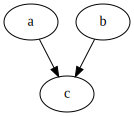

In [77]:
opt_cdags = opttree.to_minimal_context_graphs()
for key, val in opt_cdags.items():
    agraph = nx.nx_agraph.to_agraph(val)
    agraph.layout("dot")
    agraph.draw("testing/"+str(key) + "_opt.png",
                args='-Glabel="'+str(key)+'"   ')

agraph

In [76]:
tree = ctl.find_optimal_cstree(x, max_cvars=2, alpha_tot=1.0, method="BDeu")

tree.to_df()

TypeError: _find_optimal_order() got an unexpected keyword argument 'max_cvars'

In [ ]:
order = ["a", "b", "c"]
orderscore = sc.score_order(order, x, strategy="posterior", max_cvars=2, alpha_tot=1.0, method="BDeu")
nodescores = [sc._score_order_at_level(order, level, x, strategy="posterior", max_cvars=2, alpha_tot=1.0, method="BDeu") for level in range(len(order))]
print(orderscore)
print(nodescores)
print(np.sum(nodescores))
neig = ctl.get_relocation_neighborhood(order, 1, orderscore, nodescores, x, max_cvars=2, alpha_tot=1.0, method="BDeu")
print(order)
print("nodescores: ", nodescores)

print("neig: ", list(neig))

score at level 0 : -3116.1202505997753
score at level 1 : -2123.9198080480464
score at level 2 : -3033.305429574885
-8273.345488222707
[-3116.1202505997753, -2123.9198080480464, -3033.305429574885]
-8273.345488222707
['a', 'b', 'c']
nodescores:  [-3116.1202505997753, -2123.9198080480464, -3033.305429574885]
neig:  [0.4999999999999138, 0.4999999999999138, 8.631092375820474e-114]


In [ ]:
orders, scores = ctl.gibbs_order_sampler(100000, x, max_cvars=2, alpha_tot=1.0, method="BDeu")

Calculating positional order scores for each variable: 100%|██████████| 3/3 [00:00<00:00, 1493.88it/s]


initial order: ['a', 'b', 'c']
initial score: -8273.345488222707


100%|██████████| 99999/99999 [00:24<00:00, 4079.03it/s]


In [60]:
np.random.seed(1)
random.seed(1)
p = 3
cards = [2] * p

t = ct.sample_cstree(cards, 2, 0.5, 1)
t.sample_stage_parameters(alpha=2)


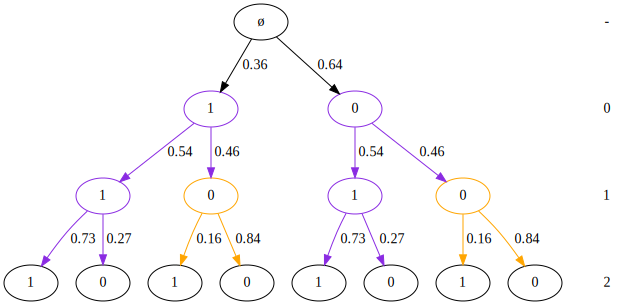

In [61]:
t.plot()

In [122]:
agraphs= t.to_minimal_context_agraphs()

None


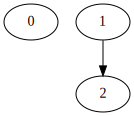

In [123]:
keys = list(agraphs.keys())
print(keys[0])
agraphs[keys[0]]

In [124]:
print(keys[1])
agraphs[keys[1]]

IndexError: list index out of range

In [125]:
np.random.seed(6)
x2 = t.sample(5000)

In [62]:
score_table, context_scores, context_counts = sc.order_score_tables(x2, max_cvars=2, alpha_tot=1.0, method="BDeu")

Context score tables:   0%|          | 0/5 [00:00<?, ?it/s]

Order score tables: 100%|██████████| 5/5 [00:00<00:00, 57.30it/s]


In [65]:
score_table

{0: {'None': -115.65853298691565,
  '1': -115.43538943560144,
  '2': -115.43538943560144,
  '3': -115.43538943560144,
  '4': -115.43538943560144,
  '1,2': -115.7652021573299,
  '1,3': -115.7652021573299,
  '1,4': -115.7652021573299,
  '2,3': -115.71036708922315,
  '2,4': -115.71036708922315,
  '3,4': -115.77232546782085,
  '1,2,3': -116.59909588788453,
  '1,2,4': -116.59909588788453,
  '1,3,4': -116.65487311568758,
  '2,3,4': -116.6009967564173,
  '1,2,3,4': -117.04887987999088},
 1: {'None': -336.48132209254885,
  '0': -336.25817854123466,
  '2': -336.25817854123466,
  '3': -336.25817854123466,
  '4': -336.25817854123466,
  '0,2': -336.5879912629631,
  '0,3': -336.5879912629631,
  '0,4': -336.5879912629631,
  '2,3': -336.58436418985553,
  '2,4': -336.58436418985553,
  '3,4': -336.6312590495524,
  '0,2,3': -337.4773193966847,
  '0,2,4': -337.4773193966847,
  '0,3,4': -337.51870122139036,
  '2,3,4': -337.52760728574174,
  '0,2,3,4': -337.98239871387574},
 2: {'None': -313.688623236297,


In [63]:
pp(context_scores)

{
    'cards': {0: 2, 1: 2, 2: 2, 3: 2, 4: 2},
    'scores': {
        0: {
            '1=0': -39.11630953855279,
            '1=0,2=0': -10.99265420657177,
            '1=0,2=1': -30.842523574709443,
            '1=0,3=0': -33.74740937548981,
            '1=0,3=1': -7.216069172038738,
            '1=0,4=0': -13.915963619242982,
            '1=0,4=1': -27.913703146431416,
            '1=1': -77.47632717820227,
            '1=1,2=0': -19.82416605289377,
            '1=1,2=1': -59.91419975201417,
            '1=1,3=0': -55.643919093360466,
            '1=1,3=1': -25.079058062325473,
            '1=1,4=0': -28.010427955246367,
            '1=1,4=1': -52.63760692848499,
            '2=0': -28.136463619930588,
            '2=0,3=0': -23.194019945272,
            '2=0,3=1': -7.12262938668294,
            '2=0,4=0': -16.563555851308063,
            '2=0,4=1': -12.576357844983859,
            '2=1': -87.88315656166648,
            '2=1,3=0': -65.80640106094802,
            '2=1,3=1': -25.3554

In [64]:
orders2, scores2 = ctl.gibbs_order_sampler(2000, score_table)

initial order: [3, 4, 1, 0, 2]
initial score: -1373.8325918125984


Gibbs order sampler:   0%|          | 0/2000 [00:00<?, ?it/s]

Gibbs order sampler: 100%|██████████| 2000/2000 [00:00<00:00, 3736.84it/s]


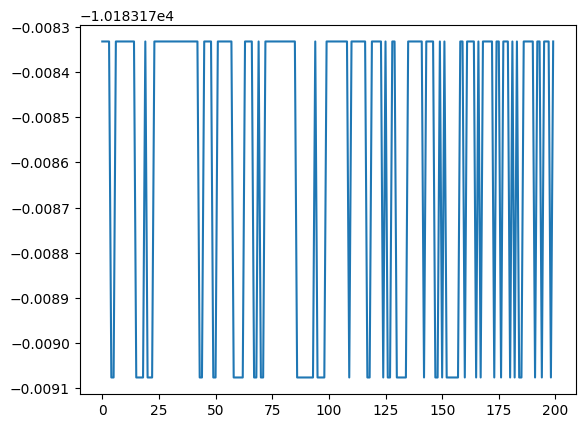

In [129]:
plt.plot(scores2[:200])

In [130]:
# Get the individual var locations on the order
var_positions = {var: [x.index(var) for x in orders2] for var in orders2[0]}
var_positions["iteration"] = list(range(len(orders2))) 
plotdf = pd.DataFrame(var_positions)

<Axes: xlabel='iteration'>

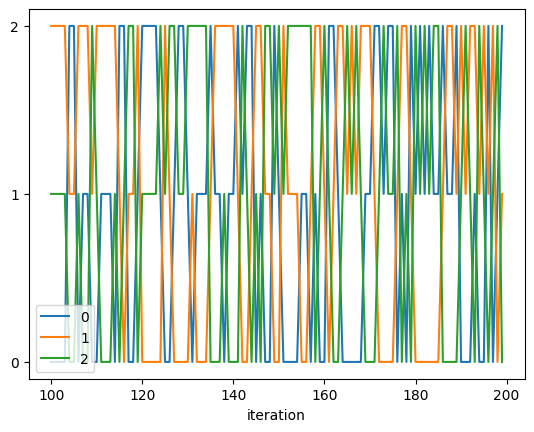

In [131]:
plotdf[100:200].plot(x = "iteration", y = range(p), yticks=range(len(orders2[0])))

In [132]:
max(scores2)

-10183.178331466606

In [133]:
maxi = scores2.index(max(scores2))

In [134]:
maporder = orders2[maxi]
maporder

[2, 0, 1]

In [154]:
opttree = ctl._optimal_cstree_given_order(maporder, context_scores,
                                          max_cvars=2,
                                          alpha_tot=1, method="BDeu")

# for lev, staging in opttree.stages.items():
#   print(lev)
#   for stage in staging:
#     print(stage.color)
  


level: -1, stage: []
stage color: blueviolet
level: 0, stage: []
stage color: blueviolet
level: 1, stage: [{0, 1}]
stage color: blueviolet


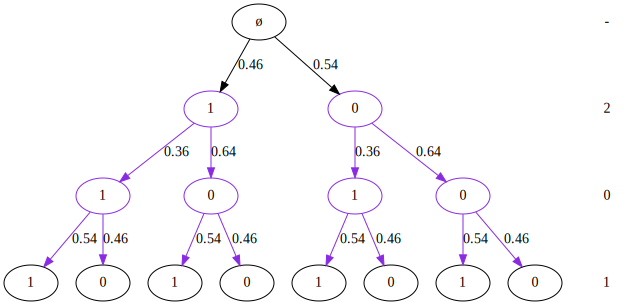

In [152]:
opttree.estimate_stage_parameters(x2, alpha_tot=2.0, method="BDeu")
opttree.plot()

In [ ]:
s2 = sc.score_order(range(len(score_table)), x2, max_cvars=2, alpha_tot=1.0, method="BDeu", strategy="posterior")

score at level 0 : -3370.339615239277
score at level 1 : -3336.7562984763604
score at level 2 : -3396.2725918635624
score at level 3 : -1333.7035970800987
score at level 4 : -3412.105181799819


In [ ]:
s2

-14849.177284459118

In [ ]:
orders2